In [1]:
'''
Windows: Open Anaconda prompt
conda create --name tigre_env -c anaconda -c ccpi -c conda-forge  python tigre simpleitk ipykernel opencv astropy tomopy nibabel scikit-image scikit-learn scipy tqdm scikit-learn-intelex jupyter ipywidgets
conda activate tigre_env

conda list --export > conda-package-list.txt
conda create -n tigre_env --file conda-package-list.txt
'''

import json
import math
import multiprocessing
import os
import sys
from __future__ import division


import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import tomopy
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from PIL import Image
from scipy import interpolate
from scipy.ndimage import median_filter
from scipy.signal import medfilt2d
from skimage.registration import phase_cross_correlation
from tqdm import trange, tqdm
from typing import List
import SimpleITK as sitk
import datetime


import tigre
import tigre.algorithms as algs
from tigre.utilities.geometry import Geometry

import shared_functions as s

kernel = Gaussian2DKernel(x_stddev=2)

drive = 'f:\\'
# basefolder = os.path.join(drive,'jasper','data','20220726_scanseries')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220822_ffpe_WhateverBreast')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220825_LegoMan')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220822_Al_Phantom_Recon_Alignment')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220822_ffpe_WhateverBreast')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220805_tumourWhateverBreast')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220727_HamnCheeseseries_M')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220929_Legoman_al_filter_110_um_variable_exposures')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220930_Legoman_al_filter_110_um_fixed_exposures')
# base_folder = os.path.join(drive, 'jasper', 'data', '20221003_Legoman_al_filter_110_um') # centre_of_rotation_offset_x_mm = 0.1
# base_folder = os.path.join(drive, 'jasper', 'data', '20221004_Legoman_al_filter_220_um') # 4 keV only
# base_folder = os.path.join(drive, 'jasper', 'data', '20221004_Legoman_al_filter_220_um') # 4 keV only
base_folder = os.path.join(drive, 'jasper', 'data', '20221004_Legoman_al_filter_500_um') 

base_json_file = os.path.join(base_folder, 'scan_settings.json')
results_folder = os.path.join(base_folder, 'results')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

chip_indices = (0,1,2,3)

# Make a list of globals for the reconstruction setting, and log them in a json file
gReconParams = dict()

gReconParams['pixels'] = 512  # (pixels)
gReconParams['pixel_pitch'] = 0.055  # (mm)
gReconParams['fill_gap'] = True
gReconParams['median_filter'] = False
gReconParams['bad_pixel_correction'] = True
gReconParams['recon_voxels'] = (
    gReconParams['pixels'], gReconParams['pixels'], gReconParams['pixels'])  # number of voxels (vx)
 
'''
9.5+9+30+100+30+9+9+0.055+1.035 = 197.59 mm

9.5 mm   - Tube focal spot to tube face
9 mm     - Edge of tube to the sample stage edge
30 mm    - Radius of the sample stage
100 mm   - Sample stage maximum range (variable for magnified scans - TODO implement this...)
30 mm    - Radius of the sample stage
9 mm     - Edge of sample stage to detector face (not mylar)
9 mm     - Detector face to mylar 
0.055 mm - Mylar cover thickness
1.035 mm - Mylar to Si sensor surface
'''
gReconParams['distance_source_detector'] = 197.59
gReconParams['z_stage_distance_mm'] = s.get_sample_z_from_first_scan_json(base_json_file) # Varies between 0 and 100 mm
print(gReconParams['z_stage_distance_mm'])
'''
30 mm    - Radius of the sample stage
9 mm     - Edge of sample stage to detector face (not mylar)
9 mm     - Detector face to mylar 
0.055 mm - Mylar cover thickness
1.035 mm - Mylar to Si sensor surface
'''
gReconParams['distance_object_detector'] = 30 + \
    gReconParams['z_stage_distance_mm'] + 9+9+0.055+1.035  # (mm)
gReconParams['detector_rotation'] = (math.radians(0.), 0., 0.)  # (mm)

assert gReconParams['z_stage_distance_mm'] < 100 and gReconParams['z_stage_distance_mm'] >= 0


DSD = gReconParams['distance_source_detector']
DSO = DSD - gReconParams['distance_object_detector']
a = gReconParams['pixels'] * gReconParams['pixel_pitch'] / (((DSD-DSO) / DSO) + 1)
gReconParams['recon_size'] = (a, a, a)
# gReconParams['recon_size'] = (512*0.055,512*0.055,512*0.055)

print(gReconParams)

# 20220805_tumourWhateverBreast
# centre_of_rotation_offset_x_mm = -0.27  # s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=25)
# centre_of_rotation_offset_y_mm = -0.24

# 20220822_ffpe_WhateverBreast
# centre_of_rotation_offset_x_mm = 0.16885  # s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=25)
# centre_of_rotation_offset_y_mm = 0.0

# 20220727_HamnCheeseseries_M
centre_of_rotation_offset_x_mm = 0.43725  # s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=25)
centre_of_rotation_offset_y_mm = 0

print(f'centre_of_rotation_offset_x_mm = {centre_of_rotation_offset_x_mm} (mm)')
print(f'centre_of_rotation_offset_y_mm = {centre_of_rotation_offset_y_mm} (mm)')

0.0
{'pixels': 512, 'pixel_pitch': 0.055, 'fill_gap': True, 'median_filter': False, 'bad_pixel_correction': True, 'recon_voxels': (512, 512, 512), 'distance_source_detector': 197.59, 'z_stage_distance_mm': 0.0, 'distance_object_detector': 49.089999999999996, 'detector_rotation': (0.0, 0.0, 0.0), 'recon_size': (21.163824080166002, 21.163824080166002, 21.163824080166002)}
centre_of_rotation_offset_x_mm = 0.43725 (mm)
centre_of_rotation_offset_y_mm = 0 (mm)


In [2]:
spectral_projs_th0, spectral_open_th0, spectral_projs_th1, spectral_open_th1, th0_list, th1_list, exp_time, angles, z_offset, detector_x_offsets, detector_y_offsets, th0_dacs_list, th1_dacs_list = \
    s.load_or_generate_data_arrays(base_json_file, base_folder, results_folder, gReconParams)

Loading existing numpy files, should take <7.5 seconds


100%|██████████| 5/5 [00:00<00:00, 211.16it/s]


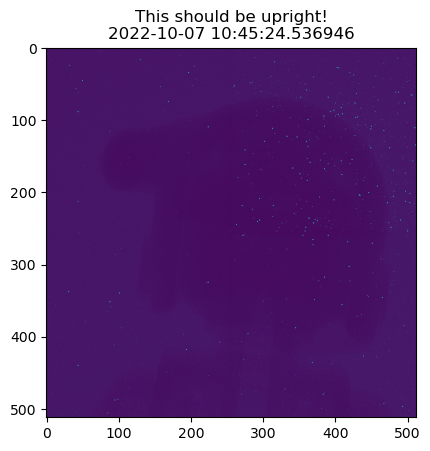

In [3]:
''' Flip in both axes for the Legoman_al_filter_100_um_ datasets... 
Going from (2,3,0,1) to (0,1,2,3) '''

if chip_indices == (0,1,2,3):
    spectral_projs_th0 = np.flip(np.flip(spectral_projs_th0, axis=2), axis=3)
    spectral_open_th0  = np.flip(np.flip(spectral_open_th0, axis=2), axis=3)
    spectral_projs_th1 = np.flip(np.flip(spectral_projs_th1, axis=2), axis=3)
    spectral_open_th1  = np.flip(np.flip(spectral_open_th1, axis=2), axis=3)
plt.title(f'This should be upright!\n{datetime.datetime.now()}')
plt.imshow(spectral_projs_th0[0,0,:,:])
plt.show()

In [4]:
open_mean_th0_all_dacs = np.mean(spectral_open_th0, axis=1)
open_mean_th1_all_dacs = np.mean(spectral_open_th1, axis=1)

for i in range(open_mean_th0_all_dacs.shape[0]):
    # print(i, open_mean_th0_all_dacs.shape, open_mean_th0_all_dacs.shape[0])  # E.g. 0 (9, 512, 512) 9
    open_mean_th0_all_dacs[i, :, :] /= exp_time[i]
    open_mean_th1_all_dacs[i, :, :] /= exp_time[i]

for i in range(spectral_projs_th0.shape[0]):
    spectral_projs_th0[i, :, :, :] = spectral_projs_th0[i, :, :, :] / exp_time[i]
    spectral_projs_th1[i, :, :, :] = spectral_projs_th1[i, :, :, :] / exp_time[i]


In [5]:
# print(spectral_projs_th0.shape)

# _global_detector_shift_y = s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=20)
# print(_global_detector_shift_y)
# global_detector_shift_y=0.12
results_folder = os.path.join(base_folder, 'results')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [11]:

h = gReconParams['pixels']//2

regressions_0, residuals_0 = s.fit_proj_data_values_polynomial(spectral_projs_th0[:,:, h:, h:], th0_dacs_list[:, 0]) # BR
regressions_1, residuals_1 = s.fit_proj_data_values_polynomial(spectral_projs_th0[:,:, h:,:h ], th0_dacs_list[:, 1]) # BL
regressions_2, residuals_2 = s.fit_proj_data_values_polynomial(spectral_projs_th0[:,:,:h, :h ], th0_dacs_list[:, 2]) # TL
regressions_3, residuals_3 = s.fit_proj_data_values_polynomial(spectral_projs_th0[:,:,:h,  h:], th0_dacs_list[:, 3]) # TR

proj_data_fits =np.zeros((3,spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3]))

proj_data_fits[:,:, h:, h:] = regressions_0
proj_data_fits[:,:, h:,:h ] = regressions_1
proj_data_fits[:,:,:h, :h ] = regressions_2
proj_data_fits[:,:,:h,  h:] = regressions_3

proj_data_fit_residuals =np.zeros((spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3]))
proj_data_fit_residuals[:, h:, h:] = residuals_0
proj_data_fit_residuals[:, h:,:h ] = residuals_1
proj_data_fit_residuals[:,:h, :h ] = residuals_2
proj_data_fit_residuals[:,:h,  h:] = residuals_3

# sitk.WriteImage(sitk.GetImageFromArray(proj_data_fits[0,:,:,:]), os.path.join(results_folder, 'regressions_0.nii'))
# sitk.WriteImage(sitk.GetImageFromArray(proj_data_fits[1,:,:,:]), os.path.join(results_folder, 'regressions_1.nii'))
# sitk.WriteImage(sitk.GetImageFromArray(proj_data_fits[2,:,:,:]), os.path.join(results_folder, 'regressions_2.nii'))


# sitk.WriteImage(sitk.GetImageFromArray(proj_data_fit_residuals), os.path.join(results_folder, 'regressions_residuals.nii'))

(3, 500, 256, 256)
[ 5.73106016e-02 -4.16942639e+01  3.87837992e+03]


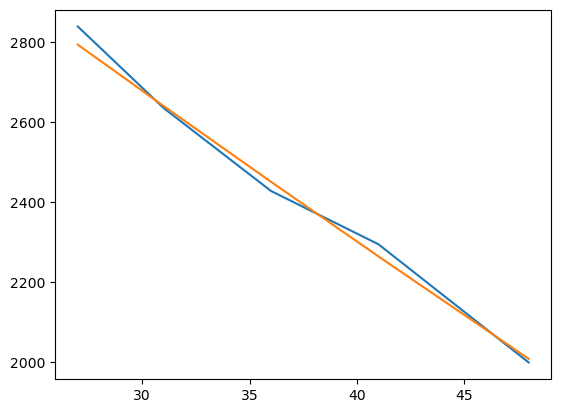

In [17]:
print(regressions_2.shape)

N = 222
x = th0_dacs_list[:, 0]
y = (regressions_2[0,0,N,N]*x**2) + (regressions_2[1,0,N,N]*x) + regressions_2[2,0,N,N]
print(regressions_2[:,0,N,N])
# print()
plt.plot(x, spectral_projs_th0[:,0,N,N])
plt.plot(x,y)
plt.show()
# print(regressions_2[2,0,N,N])

In [8]:
# ni_img = nib.Nifti1Image(spectral_projs_th0[0,:,:,:], np.eye(4)) # Do not change this to make_nifti1Image function as we do not need the geo params for this
# s.save_array(results_folder, 'Proj_th0_'+str(th0_list[0])+'proj_org.nii', ni_img)

# for i in range (spectral_projs_th0.shape[0]):
#     print(i, np.mean(spectral_projs_th0[i,:,:,:]))
#     print(i, np.count_nonzero(spectral_projs_th0[i,:,:,:] == 0))

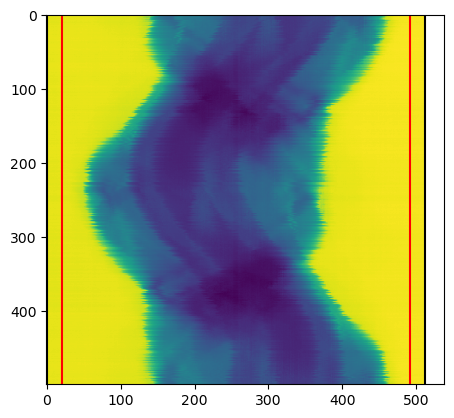

In [19]:
''' Does this selected region contain only air over the whole scan? '''
air_column_number = 20

img_check = np.median(spectral_projs_th0[0]/np.sum(spectral_open_th0[0], axis=0), axis=1)
plt.imshow(img_check)
plt.axvline(0, c='k')
plt.axvline(air_column_number, c='r')
plt.axvline(gReconParams['pixels'] - air_column_number, c='r')
plt.axvline(gReconParams['pixels'], c='k')
plt.show()

# plt.hist(img_check.flatten(), bins=200)
# plt.show()

Finding best DAC values per pixel...
Loading existing numpy file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\all_dac_values.npy


  0%|          | 0/5 [00:00<?, ?it/s]

Saving Numpy array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Projections_th0_4.0_DAC.npy


C:\Users\navrit\AppData\Local\Temp\ipykernel_30356\3811062953.py:28: RuntimeWarning: invalid value encountered in log
  ofc = -np.log(corrected_projection_data/median)


ofc.shape = (500, 512, 512)


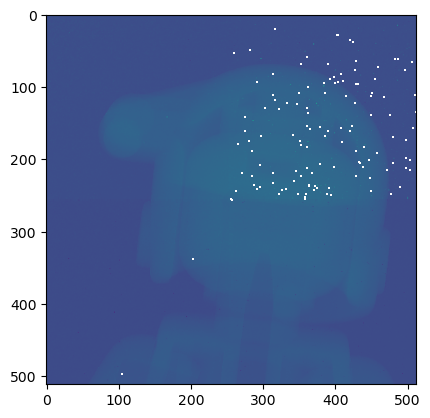

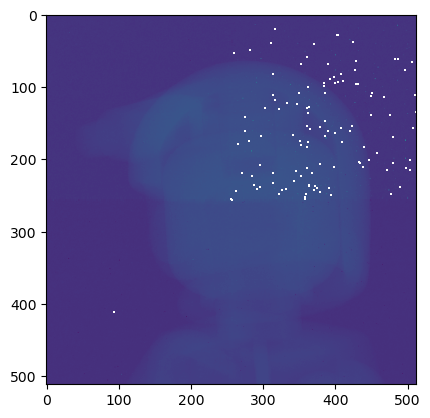

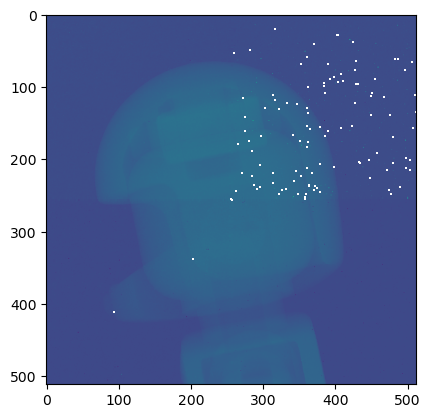

Saving Numpy array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\projs_th0_4.0OFC_interp.npy
Loading existing numpy file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\th0_bpc.npy
ofc_bpc.shape = (500, 512, 512)


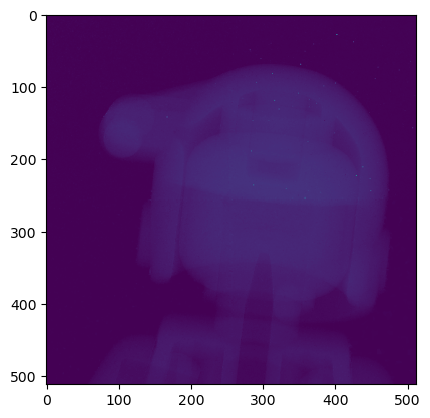

Doing find_optimal_offset!
DAC:0, centre_of_rotation_offset_x_mm: -0.0275
Doing recon finally!
dsd:  197.59 dso:  148.5
Saving Nifti array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Recon_th0_4.0OFC_BPC.nii
dsd:  197.59 dso:  148.5
Saving Nifti array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Recon_th0_4.0OFC_BPC_MF3.nii


 20%|██        | 1/5 [00:26<01:45, 26.30s/it]

Saving Numpy array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Projections_th0_5.0_DAC.npy
ofc.shape = (500, 512, 512)


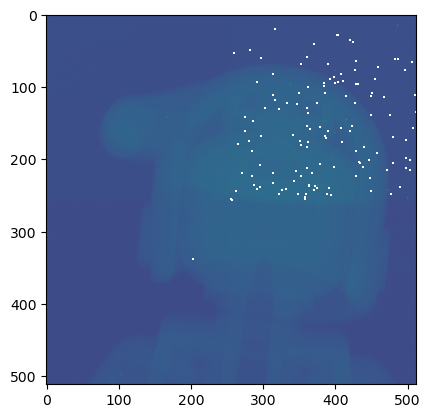

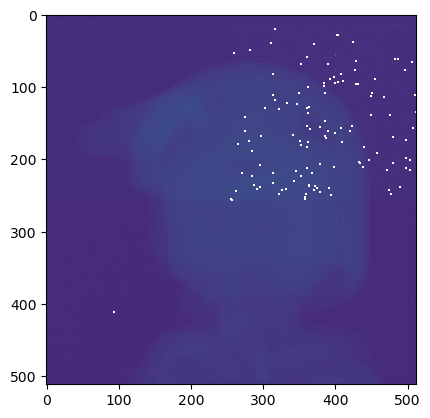

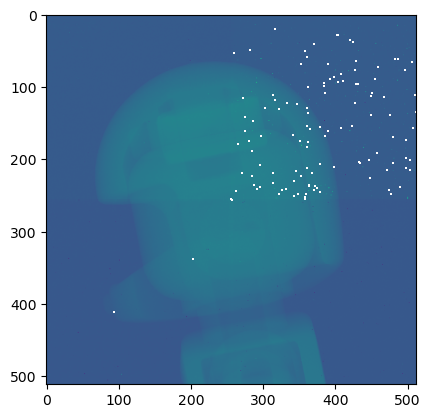

Saving Numpy array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\projs_th0_5.0OFC_interp.npy
Loading existing numpy file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\th1_bpc.npy
ofc_bpc.shape = (500, 512, 512)


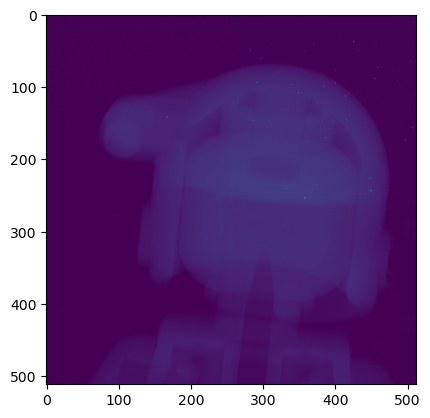

Doing find_optimal_offset!
DAC:1, centre_of_rotation_offset_x_mm: -0.0275
Doing recon finally!
dsd:  197.59 dso:  148.5
Saving Nifti array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Recon_th0_5.0OFC_BPC.nii
dsd:  197.59 dso:  148.5
Saving Nifti array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Recon_th0_5.0OFC_BPC_MF3.nii


 40%|████      | 2/5 [00:44<01:04, 21.60s/it]

Saving Numpy array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Projections_th0_6.0_DAC.npy
ofc.shape = (500, 512, 512)


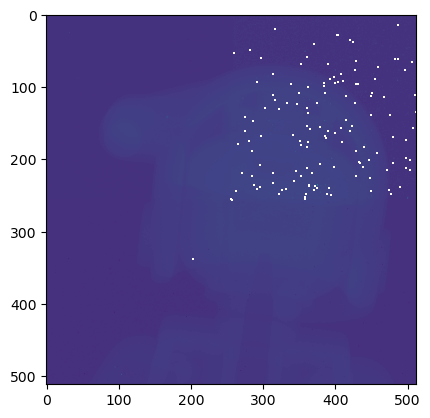

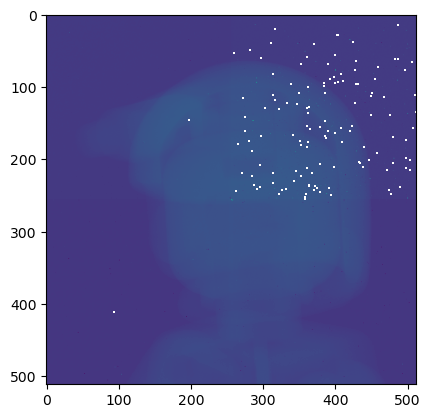

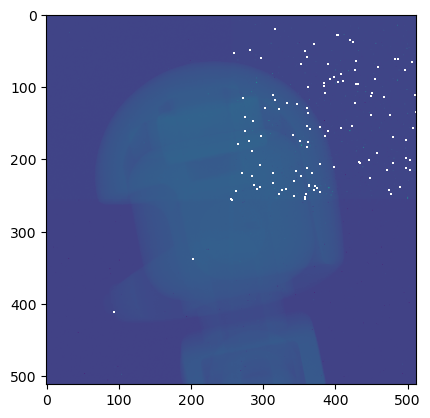

Saving Numpy array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\projs_th0_6.0OFC_interp.npy
Loading existing numpy file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\th2_bpc.npy
ofc_bpc.shape = (500, 512, 512)


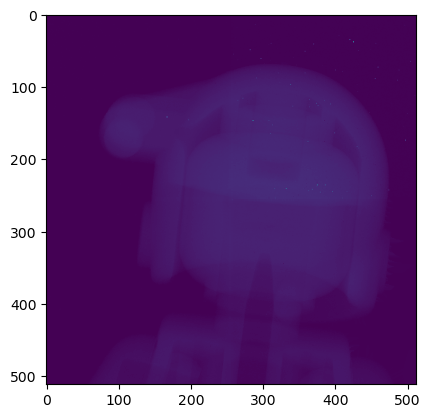

Doing find_optimal_offset!
DAC:2, centre_of_rotation_offset_x_mm: -0.0275
Doing recon finally!
dsd:  197.59 dso:  148.5
Saving Nifti array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Recon_th0_6.0OFC_BPC.nii
dsd:  197.59 dso:  148.5
Saving Nifti array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Recon_th0_6.0OFC_BPC_MF3.nii


 60%|██████    | 3/5 [01:02<00:40, 20.12s/it]

Saving Numpy array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Projections_th0_7.0_DAC.npy
ofc.shape = (500, 512, 512)


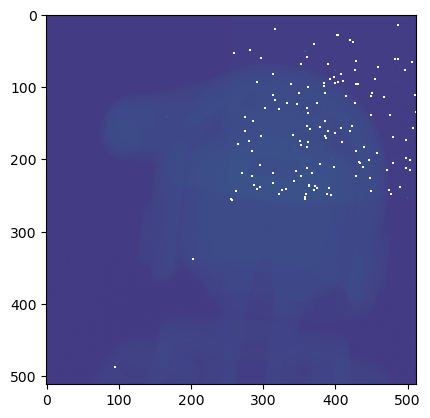

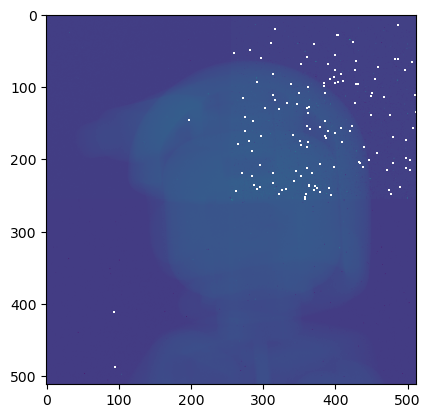

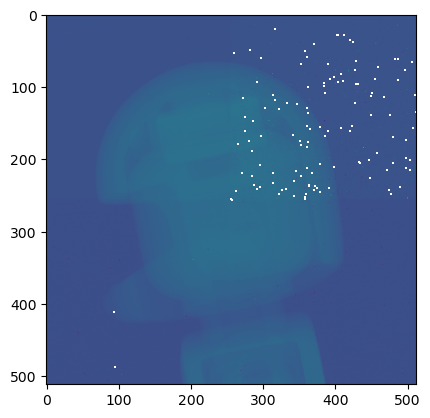

Saving Numpy array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\projs_th0_7.0OFC_interp.npy
Loading existing numpy file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\th3_bpc.npy
ofc_bpc.shape = (500, 512, 512)


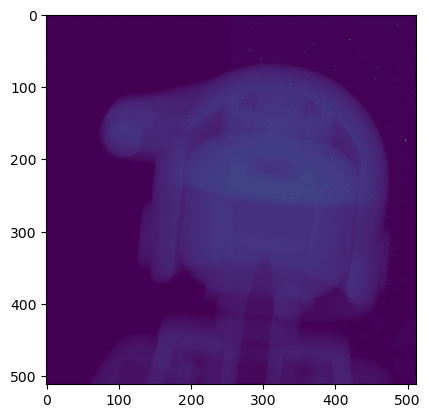

Doing find_optimal_offset!
DAC:3, centre_of_rotation_offset_x_mm: -0.0275
Doing recon finally!
dsd:  197.59 dso:  148.5
Saving Nifti array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Recon_th0_7.0OFC_BPC.nii
dsd:  197.59 dso:  148.5
Saving Nifti array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Recon_th0_7.0OFC_BPC_MF3.nii


 80%|████████  | 4/5 [01:21<00:19, 19.48s/it]

Saving Numpy array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Projections_th0_8.5_DAC.npy
ofc.shape = (500, 512, 512)


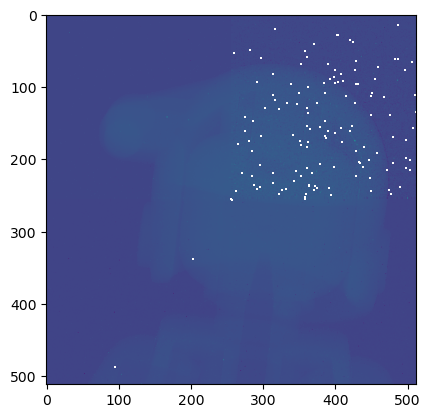

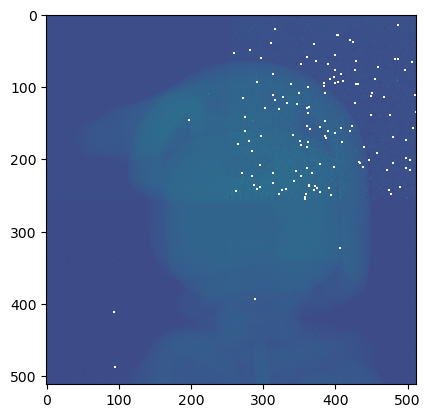

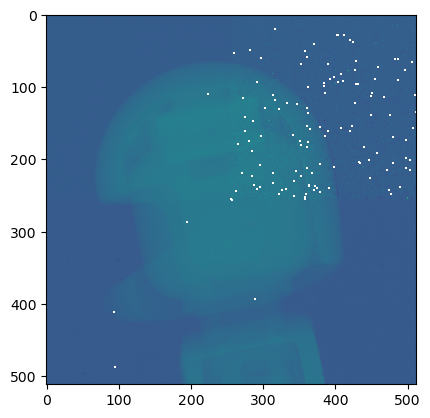

Saving Numpy array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\projs_th0_8.5OFC_interp.npy
Loading existing numpy file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\th4_bpc.npy
ofc_bpc.shape = (500, 512, 512)


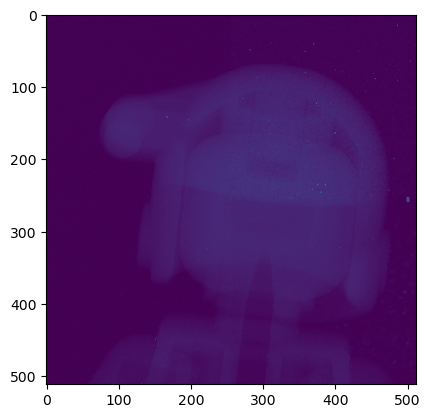

Doing find_optimal_offset!
DAC:4, centre_of_rotation_offset_x_mm: -0.0275
Doing recon finally!
dsd:  197.59 dso:  148.5
Saving Nifti array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Recon_th0_8.5OFC_BPC.nii
dsd:  197.59 dso:  148.5
Saving Nifti array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Recon_th0_8.5OFC_BPC_MF3.nii


100%|██████████| 5/5 [01:40<00:00, 20.10s/it]


In [20]:
print('Finding best DAC values per pixel...')    

# E.g. shape = (21, 512, 512)
corrected_DAC_values_from_open_images = s.save_and_or_load_npy_files(
        results_folder, f'all_dac_values.npy', lambda: s.generate_correct_dac_values(gReconParams, open_mean_th0_all_dacs, th0_dacs_list, chip_indices, plot=True, poly_order=2, open_img_path=results_folder))

'''
for t in scanned_thresholds:
    for p in projections:
        x = get correct dac for this pixel
        f = fit / interpolate for this pixel, using projection data
        y = f(x) --- get corresponding y value for that x
        img[t,p,i,j] = y
'''
for dac_index in trange(0, spectral_projs_th0.shape[0]):
    d = corrected_DAC_values_from_open_images[dac_index] # (512, 512)
    corrected_dacs_from_open_images_for_n_projections = np.repeat(d[np.newaxis, :, :], spectral_projs_th0.shape[1], axis=0).flatten() # (Projections, x/y, y/x) FLATTENED
    proj_data_fits_flat = proj_data_fits.reshape(proj_data_fits.shape[0], -1) # Transpose and flatten projection data
    reconstructed_proj_data_flat = (proj_data_fits_flat[0, :]*corrected_dacs_from_open_images_for_n_projections**2) + \
                                    (proj_data_fits_flat[1, :]*corrected_dacs_from_open_images_for_n_projections**1) + \
                                    proj_data_fits_flat[2, :] 


    corrected_projection_data = reconstructed_proj_data_flat.reshape(spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3])
    s.save_array(results_folder, 'Projections_th0_' + str(th0_list[dac_index])+'_DAC.npy', corrected_projection_data)
    
    median = (np.nanmedian(corrected_projection_data[:, :, 0:air_column_number]) + np.nanmedian(corrected_projection_data[:, :, gReconParams['pixels']-air_column_number:gReconParams['pixels']]))/2
    ofc = -np.log(corrected_projection_data/median)
    # print(f'ofc.shape = {ofc.shape}')
    # plt.imshow(ofc[0, :, :])
    # plt.show()
    # plt.imshow(ofc[62, :, :])
    # plt.show()
    # plt.imshow(ofc[125, :, :])
    # plt.show()
    s.save_array(results_folder, 'projs_th0_'+str(th0_list[dac_index])+'OFC_interp.npy', ofc)

    ofc_bpc = s.save_and_or_load_npy_files(results_folder, f'th{dac_index}_bpc.npy', lambda: s.generate_bad_pixel_corrected_array(ofc, gReconParams))
    # print(f'ofc_bpc.shape = {ofc_bpc.shape}')
    # plt.imshow(ofc_bpc[0, :, :])
    # plt.show()

    if dac_index == 0:
        stage_offset =  0.325
    else:
        stage_offset = centre_of_rotation_offset_x_mm 
    print('Doing find_optimal_offset!')
    # TODO s.find_optimal_offset is being updated with Jasper's fixes...
    centre_of_rotation_offset_x_mm = -0.0275 #s.find_optimal_offset(gReconParams, ofc_bpc, angles, detector_x_offsets, detector_y_offsets, stage_offset=stage_offset, search_range=20)
    print('DAC:{}, centre_of_rotation_offset_x_mm: {}'.format(dac_index, centre_of_rotation_offset_x_mm))
    print('Doing recon finally!')
    img_th0, geo = s.recon_scan(gReconParams, ofc_bpc, angles, detector_x_offsets,
                         detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    
    ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    s.save_array(results_folder, 'Recon_th0_'+str(th0_list[dac_index])+'OFC_BPC.nii', ni_img)
    
    ofc_bpc_mf = s.median_filter_projection_set(ofc_bpc, 3)
    img_th0, geo = s.recon_scan(gReconParams, ofc_bpc_mf, angles, detector_x_offsets,
                         detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    s.save_array(results_folder, 'Recon_th0_'+str(th0_list[dac_index])+'OFC_BPC_MF3.nii', ni_img)

-0.0275
-0.0 -0.0
-0.0 -0.0
28.665


100%|██████████| 70/70 [00:17<00:00,  4.07it/s]


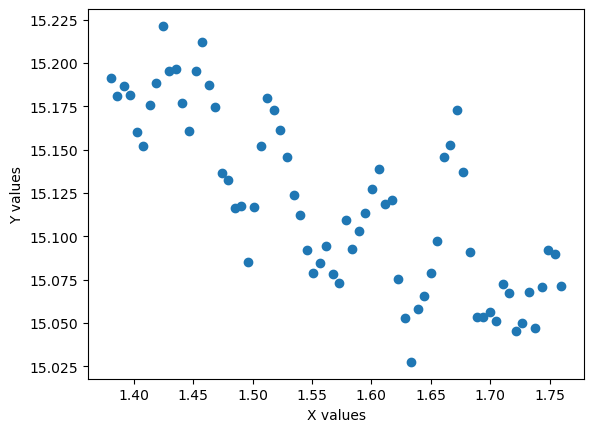

In [ ]:
print(centre_of_rotation_offset_x_mm)
centre_of_rotation_offset_x_mm = s.find_optimal_offset(gReconParams, ofc_bpc, angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=35)

In [ ]:
print(f'th = {dac}, finding optimal offset')
global_detector_shift_y = -.02 #find_optimal_offset(spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stageoffset=0, searchrange=25)
print(f'global_detector_shift_y = {global_detector_shift_y} (mm)')

ni_img = nib.Nifti1Image(ofc_bpc_mf, np.eye(4))
s.save_array(results_folder, 'Proj_th0_'+str(th0_list[dac])+'OFC_BPC_MF.nii', ni_img)

print('Doing recon finally!')
img_th0 = s.recon_scan(gReconParams, ofc_bpc, angles, z_offset, detector_x_offsets,
                    detector_y_offsets, global_detector_shift_y)

ni_img = nib.Nifti1Image(img_th0, np.eye(4))
s.save_array(results_folder, 'Recon_th0_'+str(th0_list[dac])+'OFC_BPC.nii', ni_img)

img_th0 = s.recon_scan(gReconParams, ofc_bpc_mf, angles, z_offset, detector_x_offsets,
                    detector_y_offsets, global_detector_shift_y)
ni_img = nib.Nifti1Image(img_th0, np.eye(4))
s.save_array(results_folder, 'Recon_th0_'+str(th0_list[dac])+'OFC_BPC_MF.nii', ni_img)


th = 4, finding optimal offset
global_detector_shift_y = -0.02 (mm)
Saving Nifti array file: f:\jasper\data\20221004_Legoman_al_filter_500_um\results\Proj_th0_8.5OFC_BPC_MF.nii
Doing recon finally!
dsd:  197.59 dso:  148.5


c:\Users\Medipix3_Bois\miniconda3\lib\site-packages\nibabel\arrayproxy.py:428: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asanyarray(obj).dtype


AttributeError: 'tuple' object has no attribute 'shape'